# **Challenge: Iterate and evaluate your classifier**

In [68]:
%matplotlib inline
import clf
import string
import pandas as pd
import scipy
import sklearn
import collections
import numpy as np
import pandas_summary
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split

In [69]:
imdb_raw = pd.read_csv('imdb_labelled.txt', delimiter= '\t', header=None)
imdb_raw.columns = ['text', 'sentiment']

imdb_raw.head()

,text,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [70]:
# Make a copy of the original dataframe
df = imdb_raw.copy()

In [71]:
# Randomly chosen keywords from examining the dataset
keywords = ['good', 'fun', 'pure', 'brilliance', 'lovely', 'boasts', 'love', 'excellent', 'convincing', 'riveting',
            'great', 'true', 'classic', 'terrific', 'funny', 'touching', 'joy', 'genius', 'superb', 'awesome', 'worth',
            'nice', 'cool', 'well', 'exciting', 'crap', 'doomed', 'lame', 'unfunny', 'generic', 'not', 'pointless', 'negative', 
            'insipid', 'disappointing', 'weaker', 'terrible', 'boring', 'worst', 'stupid', 'torture', 'drag', 'lacks', 'uninteresting', 
            'unremarkable', 'bore', 'waste', 'unfortunately', 'bad', 'sucked']

for key in keywords:
    df[str(key)] = df.text.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

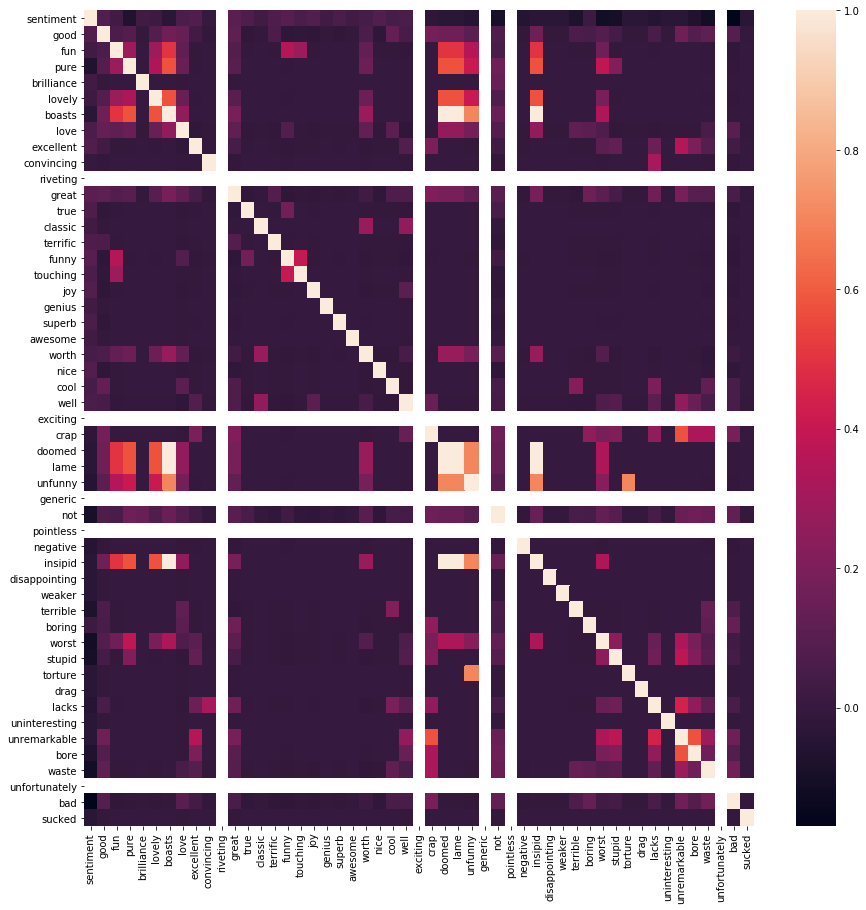

In [72]:
# Plot the correlation map
plt.figure(figsize=(15,15))
sns.heatmap(df.corr())

## **Original Model**

In [73]:
data = df[keywords]
target = df['sentiment']

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Train the model to fit the training dataset
bnb.fit(data, target)

# Store the predictions in a new variable
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

accuracy = 100*(1 - (target != y_pred).sum()/data.shape[0])

print("Percent accuracy: ", accuracy)

Number of mislabeled points out of a total 748 points : 287
Percent accuracy:  61.6310160428


## **Iteration 1**

For the first iteration, we will attempt to clean the reviews (including removing all digits and punctuation, as well as correcting spelling mistakes).

In [74]:
stop = stopwords.words('English')

# Make all text lowercase
df['text'] = df.text.apply(lambda x: x.lower())

# Make a translation table for punctuation
table_punctuation = str.maketrans('', '', string.punctuation)

# Remove all common punctuation
df['text'] = df.text.apply(lambda x: x.translate(table_punctuation))

# Make a translation table for digits
table_digits = str.maketrans('', '', string.digits)

# Remove all numbers
df['text'] = df.text.apply(lambda x: x.translate(table_digits))

# Remove all stopwords
df['text'] = df.text.apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

# Correct spelling errors
df['text'] = df.text.apply(lambda x: str(TextBlob(x).correct()))

data = df[keywords]
target = df['sentiment']

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Train the model to fit the training dataset
bnb.fit(data, target)

# Store the predictions in a new variable
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

accuracy = 100*(1 - (target != y_pred).sum()/data.shape[0])

print("Percent accuracy: ", accuracy)

Number of mislabeled points out of a total 748 points : 287
Percent accuracy:  61.6310160428


There was no change in the accuracy level for our updated classifier; thus, cleaning the movie reviews does not seem to have any effect on our classifier's performance. We will continue to iterate below by tuning and adding features.

# **Iteration 2**

For the second iteration we will expand our list of keywords by extracting the 100 most common positive and negative keywords directly from the dataset. Then we will store a list of all positive, negative, and overlapping keywords, and add them as individual features to our original dataframe.

In [75]:
def most_common_words(df, sentiment):
    word_count = collections.Counter()
    for index, row in df[df.sentiment == sentiment].iterrows():
        word_count.update(row['text'].split())
    return sorted(word_count, key=word_count.get, reverse=True)

positive_keywords_set = set(most_common_words(df, 1)[:100])
negative_keywords_set = set(most_common_words(df, 0)[:100])

positive_keywords = list(positive_keywords_set - negative_keywords_set)
negative_keywords = list(negative_keywords_set - positive_keywords_set)
overlapping_keywords = list(positive_keywords_set & negative_keywords_set)

df_copy = df.copy()

for key in (positive_keywords + negative_keywords + overlapping_keywords):
    df_copy[key] = df.text.apply(lambda x: key in x.split())

data = df_copy[positive_keywords + negative_keywords + overlapping_keywords]
target = df_copy['sentiment']

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Train the model to fit the training dataset
bnb.fit(data, target)

# Store the predictions in a new variable
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

accuracy = 100*(1 - (target != y_pred).sum()/data.shape[0])

print("Percent accuracy: ", accuracy)

Number of mislabeled points out of a total 748 points : 165
Percent accuracy:  77.9411764706


By extracting the 100 most common keywords directly from the imdb reviews, we were able to increase the accuracy of our model all the way up to 77.94%. Using only a limited set of keywords significantly deteriorates the performance of our classifier.

# **Iteration 3**

We can run another iteration with a higher sample size of keywords to see if it significantly improves our performance. This will help us quantify the effect of tuning the sample size. Here, we will increase it to 1000.

In [76]:
def most_common_words(df, sentiment):
    word_count = collections.Counter()
    for index, row in df[df.sentiment == sentiment].iterrows():
        word_count.update(row['text'].split())
    return sorted(word_count, key=word_count.get, reverse=True)

positive_keywords_set = set(most_common_words(df, 1)[:1000])
negative_keywords_set = set(most_common_words(df, 0)[:1000])

positive_keywords = list(positive_keywords_set - negative_keywords_set)
negative_keywords = list(negative_keywords_set - positive_keywords_set)
overlapping_keywords = list(positive_keywords_set & negative_keywords_set)

df_copy = df.copy()

for key in (positive_keywords + negative_keywords + overlapping_keywords):
    df_copy[key] = df.text.apply(lambda x: key in x.split())

data = df_copy[positive_keywords + negative_keywords + overlapping_keywords]
target = df_copy['sentiment']

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Train the model to fit the training dataset
bnb.fit(data, target)

# Store the predictions in a new variable
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

accuracy = 100*(1 - (target != y_pred).sum()/data.shape[0])

print("Percent accuracy: ", accuracy)

Number of mislabeled points out of a total 748 points : 5
Percent accuracy:  99.3315508021


Our accuracy increased greatly, all the way up to an optimal 99.33% by simply increasing our sample size to 1000 positive and negative keywords each. However, up until this point we have used the training data to evaluate our model, which leads to overfitting. To combat this, we will do another iteration of the model that uses sklearn to split the data into separate train and test sets.

# **Iteration 4**

For the fourth iteration, we will use sklearn to split the data into separate train and test sets, setting the test_size parameter to 25% of the dataset. Thus, the remaining 75% of the data (randomized) will be used to train the dataset.

In [77]:
def most_common_words(df, sentiment):
    word_count = collections.Counter()
    for index, row in df[df.sentiment == sentiment].iterrows():
        word_count.update(row['text'].split())
    return sorted(word_count, key=word_count.get, reverse=True)

positive_keywords_set = set(most_common_words(df, 1)[:1000])
negative_keywords_set = set(most_common_words(df, 0)[:1000])

positive_keywords = list(positive_keywords_set - negative_keywords_set)
negative_keywords = list(negative_keywords_set - positive_keywords_set)
overlapping_keywords = list(positive_keywords_set & negative_keywords_set)

df_copy = df.copy()

for key in (positive_keywords + negative_keywords + overlapping_keywords):
    df_copy[key] = df.text.apply(lambda x: key in x.split())

data = df_copy[positive_keywords + negative_keywords + overlapping_keywords]
target = df_copy['sentiment']

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# create training sets and test sets for each of the data and the targets 
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.25, random_state=1)

# Train the model to fit the training dataset
bnb.fit(data_train, target_train)

# Store the predictions in a new variable
y_pred = bnb.predict(data_test)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target_test != y_pred).sum()
))

accuracy = 100*(1 - (target_test != y_pred).sum()/data.shape[0])

print("Percent accuracy: ", accuracy)

Number of mislabeled points out of a total 748 points : 1
Percent accuracy:  99.8663101604


Interestingly, this technique helped improve our accuracy a little bit, up to 99.87%. With this version of our classifier, we are able to achieve an optimal accuracy while simultaneously combatting the problem of overfitting. Together with our initial classifier, this completes our set of five different versions of the classifier.